In [6]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [7]:
def prot_div(left, right):
    if right == 0:
        return 0
    else:
        return left / right

def if_func(condition, state1, state2):
    if condition:
        return state1
    else:
        return state2

def read_experiment_results(full_path, iterations, epochs=100):
    dir_name = full_path
    results = []
    for it in range(iterations):
        with open(dir_name + 'iteration_' + str(it) + '.json') as json_file:
            if it % 10 == 0:
                print(it)
            data = json.load(json_file)
            results.append(data)
    print("Finished reading ", full_path)
    return results


In [8]:
run_number = ['']
iterations = 347
os_string = "w10"
results = []
if os_string == "osx":
    path = "/Users/soren/Library/Mobile Documents/iCloud~md~obsidian/Documents/obsidian/results/autolr-2022-05-10/run_"
elif os_string == "w10":
    path = "G:\\My Drive\\results\\autolr-2022-05-25\\run_"
for i in run_number: 
    results.append(read_experiment_results(path + i + '/', iterations))


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
Finished reading  G:\My Drive\results\autolr-2022-06-13\run_9/


In [9]:
from smart_phenotype import smart_phenotype
import random
import graphviz
def genealogy_string(results):
    epochs = np.arange(len(results[0]))
    lineage = []
    fitness_color = []
    occurences = {}
    rendered = set()
    prune_cutoff = 20
    string = """digraph genealogy{
fontname="Helvetica,Arial,sans-serif"
node [fontname="Helvetica,Arial,sans-serif"]
edge [fontname="Helvetica,Arial,sans-serif"]
# page = "8.2677165,11.692913" ;
ratio = "auto" ;
mincross = 2.0 ;
label = "Genealogy" ;


"""
    connections_string = ""
    for iteration in epochs:     
        for result in results:
            for indiv in result[iteration]:
                if "parent" in indiv:
                    for parent in indiv["parent"]:
                        if parent in occurences:
                            occurences[parent] += 1
                        else: 
                            occurences[parent] = 1
                        if indiv['id'] in occurences:
                            occurences[indiv['id']] += 1
                        else: 
                            occurences[indiv['id']] = 1  
                        lineage.append((parent, indiv['id'], indiv['fitness'] * -1))
                fitness_color.append((indiv['id'], indiv['fitness'] * -1))
    for parent, child, fitness in set(lineage):
        if fitness > 0.12 and occurences[parent] > prune_cutoff and occurences[child] > prune_cutoff:
            connections_string+=(f'\n "{parent}" -> "{child}" ;')    
            rendered.add(parent)
            rendered.add(child)
    for id, fitness in set(fitness_color):
        if fitness > 0.12 and id in rendered:
            string+=(f'\n "{id}" [style=filled,fillcolor="#{format(int(255-fitness*255), "x")}{format(int(255-fitness*255), "x")}ff", width={fitness*10}, height={fitness*10}] ;')

    string += connections_string + "\n }"
    with open("graph.dot", "w") as f:
        print(string,file=f)
    src = graphviz.Source(string)
    src.render('doctest-output/graph.gv', view=True).replace('\\', '/')
    return string

#print(genealogy_string(results))

------NEW BEST------
0-311--0.7926218152046204
multiply(negative(grad), constant(1.27951705e-01))
--------------------
------NEW BEST------
4-1127--0.796403040488561
multiply(negative(grad), constant(2.32625358e-02))
--------------------
------NEW BEST------
6-311--0.7964751081807273
multiply(negative(grad), constant(1.27951705e-01))
--------------------
------NEW BEST------
7-1422--0.8067854523658753
multiply(negative(grad), constant(5.07243606e-02))
--------------------
------NEW BEST------
11-1669--0.8129018187522888
multiply(negative(grad), constant(8.92170603e-02))
--------------------
------NEW BEST------
22-2147--0.8161345481872558
multiply(constant(4.18339400e-02), add(negative(grad), multiply(square(beta), constant(2.57431039e-03))))
--------------------
------NEW BEST------
39-2776--0.8165781855583191
multiply(constant(4.18339400e-02), add(negative(grad), multiply(square(constant(9.95290886e-01)), constant(0.0))))
--------------------
------NEW BEST------
45-3075--0.817854547

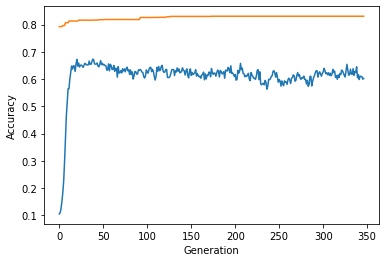

No handles with labels found to put in legend.


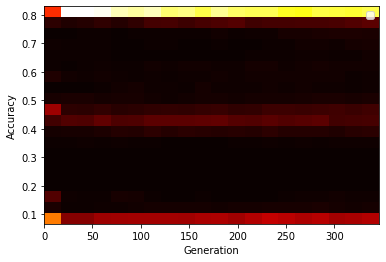

In [10]:
def plot_fit(results):
    epochs = np.arange(len(results[0]))
    #print(epochs)
    best_individuals = {}
    averages_all = []
    bests_all = []
    stds_all = []
    best_of_all = []
    stds_best_all = [] 
    indivs = []
    indivs_epochs = []
    indivs_per_epoch = []
    boa_fit = 0
    boa_indiv = None
    for iteration in epochs:
        averages_all.append([])
        bests_all.append([])
        stds_all.append([])
        indivs_per_epoch.append([])
        best_of_all.append(0)
        stds_best_all.append(0)        
        for result in results:
            all_fits = []
            best = 0
            gen_best = 0
            for indiv in result[iteration]:
                indivs.append(-1 * indiv['fitness'])
                indivs_epochs.append(iteration)
                indivs_per_epoch[iteration].append(-1 * indiv['fitness'])
                if indiv['fitness'] < best:
                    best = indiv['fitness']
                    if indiv['fitness'] < boa_fit:
                        boa_fit = best
                        print(f'------NEW BEST------\n{iteration}-{indiv["id"]}-{boa_fit}\n{smart_phenotype(indiv["phenotype"])}\n--------------------')
                        best_individuals[iteration] = {"fitness": boa_fit, "phenotype": indiv["phenotype"], "smart_phenotype": smart_phenotype(indiv["phenotype"])}
                best = best if indiv['fitness'] > best else indiv['fitness']
                all_fits.append(indiv['fitness'])
            averages_all[iteration].append(np.average(all_fits))
            stds_all[iteration].append(np.std(all_fits))
            bests_all[iteration].append(best)
        stds_best_all[iteration] = np.std(bests_all[iteration]) * -1
        stds_all[iteration] = np.std(averages_all[iteration])
        averages_all[iteration] = np.average(averages_all[iteration]) * -1
        best_of_all[iteration] = np.min(bests_all[iteration])  * -1
        bests_all[iteration] = np.average(bests_all[iteration]) * -1
    plt.plot(epochs, averages_all, label='population average')
    plt.fill_between(epochs, [i + j for i, j in zip(averages_all, stds_all)], [i - j for i, j in zip(averages_all, stds_all)], alpha=0.2)
    plt.plot(epochs, bests_all, label='best average')   
    plt.fill_between(epochs, [i + j for i, j in zip(bests_all, stds_best_all)], [i - j for i, j in zip(bests_all, stds_best_all)], alpha=0.2)
    plt.xlabel('Generation')
    plt.ylabel('Accuracy')
    plt.savefig(f'best_average_evolution{run_number}.png')
    plt.savefig(f'best_average_evolution{run_number}.pdf')
    plt.show()
    heatmap_matrix = np.zeros((10, len(epochs)))
    for epoch, fit in zip(indivs_epochs, indivs):
        for index, limit in zip(range(10), np.linspace(1,0,10)):
            if fit > limit:
                heatmap_matrix[index][epoch] += 1
                break
    heatmap, xedges, yedges = np.histogram2d(indivs_epochs, indivs, bins=20)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


    plt.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto', cmap='hot')


    #plt.plot(epochs, [0.7862666646639506 for i in bests_all], label='fixed lr val_acc')
    #plt.plot(epochs, best_of_all, label='best of all')
    plt.xlabel('Generation')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'heatmap{run_number}.png')
    plt.savefig(f'heatmap{run_number}.pdf')
    plt.show()
    return best_individuals

best_individuals = plot_fit(results)